# 1. Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# limiting GPU memory consumption if using gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus : #for multiple gpus
    tf.config.experimental.set_memory_growth(gpu,True)   

# 2. Create Folder Structures

In [4]:
# setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [9]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 3. Collect Positives and Anchors


In [10]:
# https://vis-www.cs.umass.edu/lfw/

!tar -xf lfw.tgz

In [12]:
# move lfw data to data repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [29]:
# Import uuid library to generate unique image names
import uuid 

In [32]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\cdc28d27-ded9-11ee-b864-509a4cb5d847.jpg'

In [34]:
import cv2

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250 x 250 px
    frame = frame[120:250+250,200:250+250,:]
    
    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write anchor images
        cv2.imwrite(imgname, frame)
        
    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write positive images
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # breaking
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# release the webcam        
cap.release()
# close image show frame  
cv2.destroyAllWindows()

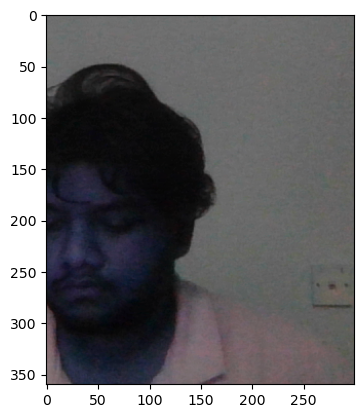

In [37]:
plt.imshow(frame)

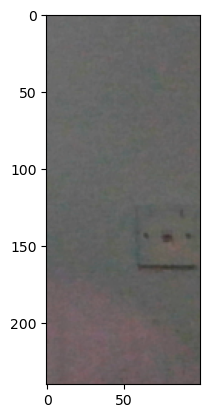

In [36]:
plt.imshow(frame[120:250+250,200:250+250,:])

# 4. Load and Preprocess Images

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\cedf3b7a-deda-11ee-9727-509a4cb5d847.jpg'

In [9]:
def preprocess(file_path):
   
    # Read images from file path
    byte_img = tf.io.read_file(file_path)
    # Load image
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize image to 100 x 100 x 3
    img = tf.image.resize(img,(100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    return img

In [10]:
img = preprocess('data\\anchor\\cedf3b7a-deda-11ee-9727-509a4cb5d847.jpg')

In [11]:
img.numpy().min()

0.009019501

In [12]:
img.numpy().max()

0.50980395

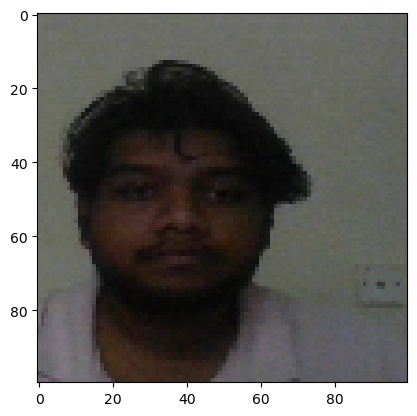

In [13]:
plt.imshow(img)

# 5. Create Labelled Dataset

In [40]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [41]:
samples =  data.as_numpy_iterator()

In [42]:
example = samples.next()

In [43]:
example

(b'data\\anchor\\ce939459-deda-11ee-9474-509a4cb5d847.jpg',
 b'data\\positive\\02386ca1-dedb-11ee-ba84-509a4cb5d847.jpg',
 1.0)

# 6. Build Train and Test Partition

In [44]:
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [45]:
res = preprocess_twin(*example)

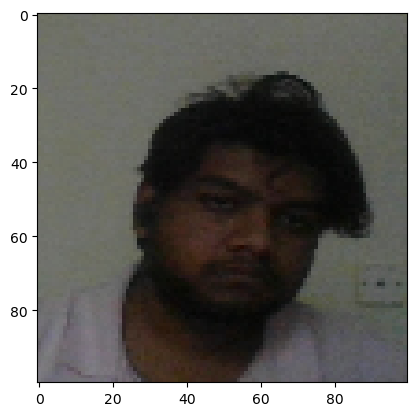

In [46]:
plt.imshow(res[1])

In [47]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [48]:
samples_2 = data.as_numpy_iterator()

In [54]:
samp = samples_2.next()

In [55]:
len(samp)

3

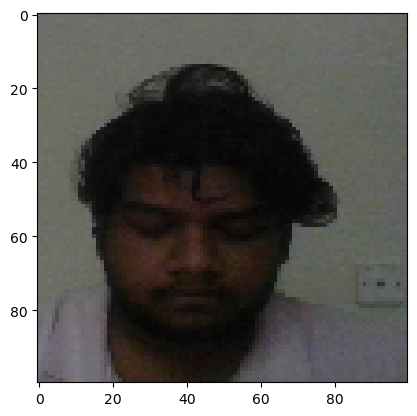

In [56]:
plt.imshow(samp[0])

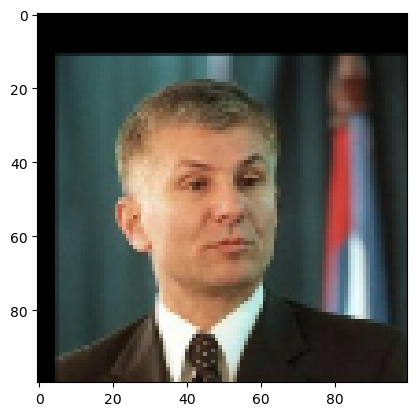

In [57]:
plt.imshow(samp[1])

In [58]:
samp[2]

0.0

In [60]:
# Training partition
train_data = data.take(round(len(data)*.7)) # 70 % of data
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [62]:
train_samples = train_data.as_numpy_iterator()

In [63]:
train_sample = train_samples.next()

In [64]:
len(train_sample[0])

16

In [68]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 7. Build Embedding Layer

In [123]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [124]:
embedding = make_embedding()

In [125]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 17, 17, 128)       26

# 8. Build Distance Layer

In [134]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)       

# 9. Build Siamese Model

In [135]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [136]:
siamese_model = make_siamese_model()

In [137]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 10. Setup Loss and Optimizer

In [138]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [139]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [141]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [142]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X,training = True)
        # Compute Loss
        loss = binary_cross_loss(y, yhat)
    print(loss) 
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

# 11. Build Training Loop

In [145]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range (1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run Train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

# 12. Train the model

In [146]:
EPOCHS = 50

In [149]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 564s 21s/step

 Epoch 2/50
27/27 [==============================] - 551s 20s/step

 Epoch 3/50
27/27 [==============================] - 558s 21s/step

 Epoch 4/50
27/27 [==============================] - 546s 20s/step

 Epoch 5/50
27/27 [==============================] - 550s 20s/step

 Epoch 6/50
27/27 [==============================] - 549s 20s/step

 Epoch 7/50
27/27 [==============================] - 569s 21s/step

 Epoch 8/50
27/27 [==============================] - 655s 24s/step

 Epoch 9/50
27/27 [==============================] - 555s 21s/step

 Epoch 10/50
27/27 [==============================] - 550s 20s/step

 Epoch 11/50
27/27 [==============================] - 570s 21s/step

 Epoch 12/50
27/27 [==============================] - 574s 21s/step

 Epoch 13/50
27/27 [==============================] - 551s 20s/step

 Epoch 14/50
27/27 [==============================] - 565s 21s/step

 Epoch 15/50
27/27 [======================

In [150]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# 13. Evaluate Model

In [152]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [153]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [154]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]

In [155]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [156]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [157]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [158]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 497ms/step
1.0 1.0


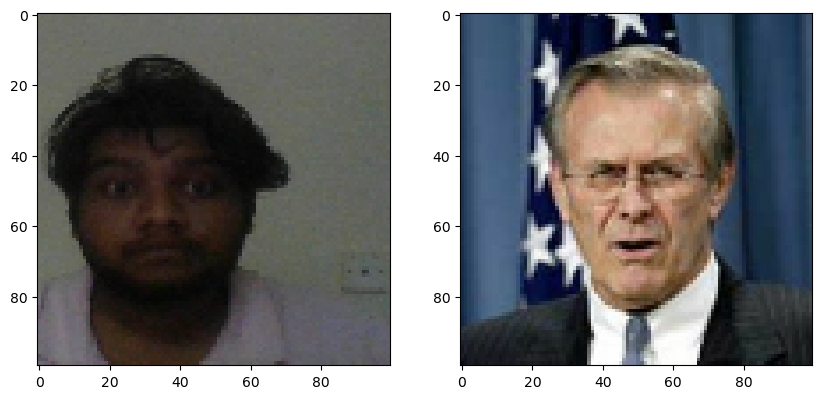

In [161]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 14. Save Model

In [162]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

C:\Users\hnwme\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [163]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [164]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 551ms/step


array([[3.8840930e-08],
       [4.8508443e-08],
       [9.9999517e-01],
       [9.9997926e-01]], dtype=float32)

In [165]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 15. Real Time Test

In [166]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [170]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 212ms/step
True
